In [2]:
#make the necessary imports of libraries essential to the code

import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import numpy as np
from IPython import display
import pickle
from torchvision.transforms import v2

In [3]:
#define the device so pytorch knows what to run on

device = 'cuda:0'
#device = 'cpu'

In [4]:
def unpickle(file): #to unpackage the data and metadata
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [5]:
metadata_path = '/kaggle/input/cifar100/meta'#get the metadata
metadata = unpickle(metadata_path) #convert it out of binary
superclass_dict = dict(list(enumerate(metadata[b'fine_label_names'])))

In [6]:
data_pre_path = '/kaggle/input/cifar100/' #grab the images from the directory
data_train_path = data_pre_path + 'train'
data_train_dict = unpickle(data_train_path)
images = data_train_dict[b'data'] #create an array of all the images in the dataset
labels = np.array(data_train_dict[b'fine_labels']) #an array of labels whose indexes correspond to the images

In [7]:
images = np.array(images)

labels = torch.tensor(labels).to(device)
images = torch.tensor(images).reshape(50000, 3, 32, 32).to(device)

images = 2*((images - images.min()) / (images.max() - images.min())) - 1 #scale the images to help with numerical stability

In [8]:
#######################################################################################################################################

In [9]:
class Diffusion: 
    def __init__(self, noise_steps=500, beta_start=1e-4, beta_end=0.02, device=device):
        self.noise_steps = noise_steps # commit the parameters to attributes of the class
        self.device = device
        self.beta_start = beta_start
        self.beta_end = beta_end

        self.beta = self.prepare_noise_schedule()
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0).to(self.device)
 
    def prepare_noise_schedule(self): # returns an array that defines the noise schedule
        lin = self.beta_end * (1 - torch.cos(torch.linspace(0, 1, self.noise_steps+1)[1:]*torch.pi)) / 2
        return lin.to(self.device)

    def noise_images(self, x, t): # noises an image up to a certain timestep
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = torch.randn_like(x).to(device)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ # returns the noised image and the noise itself

    def sample_timesteps(self, n): # randomly sample timesteps from the range
        return torch.randint(low=1, high=self.noise_steps, size=(n,))
    
    def denoise(self, model, noised, t, c, jumps=50): # uses a model to run the denoising process from any timestep
        denoiseds = []
        with torch.no_grad():
            x = noised
            for i in tqdm(reversed(range(1, t)), position=0): # loop over all the preceding timesteps in reverse
                t = (torch.ones((noised.shape[0], 1)) * i).long().to(self.device)
                predicted_noise = model(x, t, c)
                alpha = self.alpha[t][0, None, None, None]
                alpha_hat = self.alpha_hat[t][0, None, None, None]
                beta = self.beta[t][0, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                # subtract the predicted noise from the image and add back in some randomness to prevent image collapse
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise

                if i % jumps == 1:
                  denoiseds += [x]
                  denoiseds[-1] = (denoiseds[-1].clamp(-1, 1) + 1) / 2
                  denoiseds[-1] = (denoiseds[-1] * 255).type(torch.uint8)

        x = (x.clamp(-1, 1) + 1) / 2
        x = (x * 255).type(torch.uint8)
        denoiseds += [x]

        return denoiseds # an arrays that contains the image as it was at specific timesteps
    
    def sample(self, model, t=499, c=None, ngens=20): # same as the denoising process but starts at max timestep
        if c == None:
            c = torch.randint(0, 99, (ngens,)).to(device)
            
        with torch.no_grad():
            x = torch.randn((ngens, 3, 32, 32)).to(self.device)            
            for i in tqdm(reversed(range(1, t)), position=0):
                t = (torch.ones((ngens, 1)) * i).long().to(self.device)
                predicted_noise = model(x, t, c)
                alpha = self.alpha[t][0, None, None, None]
                alpha_hat = self.alpha_hat[t][0, None, None, None]
                beta = self.beta[t][0, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
                
        x = (x.clamp(-1, 1) + 1) / 2
        x = (x * 255).type(torch.uint8)
        
        return x, c

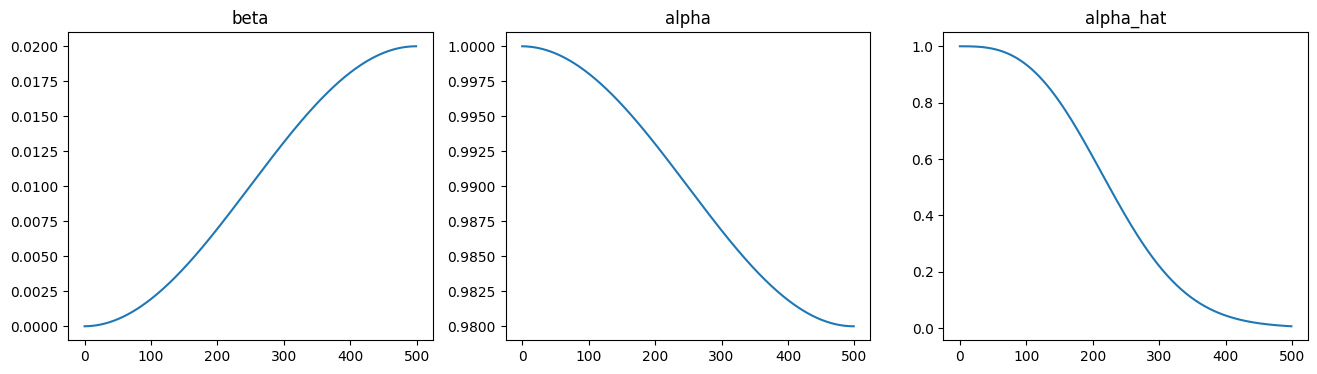

In [10]:
diffusion = Diffusion() # define the diffusion class

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

axes[0].set_title('beta')
axes[1].set_title('alpha')
axes[2].set_title('alpha_hat')

# make plots of the noise schedule parameters
    
axes[0].plot(diffusion.beta.detach().cpu().detach().numpy())
axes[1].plot(diffusion.alpha.cpu().detach().numpy())
axes[2].plot(diffusion.alpha_hat.cpu().detach().numpy())

In [11]:
def normalise(img): # normalises an image between 0 and 1
    return (img - img.min()) / (img.max() - img.min())

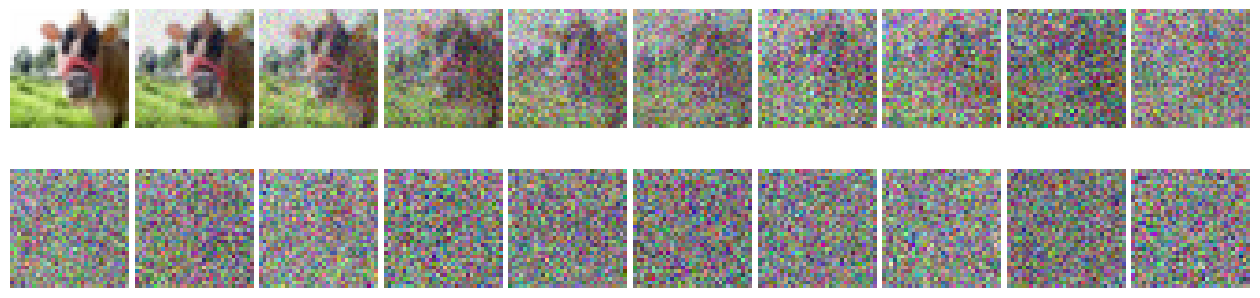

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(16, 9))

noiseds = []
for i in range(0, 500, 25): # run the forward noising process
    noised, _ = diffusion.noise_images(normalise(images[0]), torch.tensor([i]))
    noiseds += [noised]

fig.subplots_adjust(hspace=-0.7, wspace=0.05)

# show a grid of images that represent 

for i, img in enumerate(noiseds[-20:]):
  axes[i // 10, i % 10].imshow(normalise(img[0]).cpu().detach().numpy().swapaxes(0, 2).swapaxes(0, 1), cmap='gray')
  axes[i // 10, i % 10].axis('off')

In [13]:
################################################################################################################

In [14]:
def pos_encoding(t, channels=64, device=device): # sinusoidal embeddings for timestep
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

In [15]:
class ResNet(nn.Module): # backbone class of a residual convolutional stack
    def __init__(self, inc, outc, embdim=64, device=device):
        super().__init__()
        
        self.crossemb = nn.Sequential(
            nn.Linear(2*embdim, embdim),
            nn.SiLU(),
            nn.Linear(embdim, embdim),
            nn.SiLU()
        ) # perception over the conditional information
        self.inj1 = nn.Linear(embdim, inc)
        self.inj2 = nn.Linear(embdim, outc)
            
        self.gn1 = nn.GroupNorm(4, inc) # normalise outputs
        self.c1 = nn.Conv2d(inc, outc, 3, 1, 1)
        
        self.gn2 = nn.GroupNorm(4, outc)
        self.c2 = nn.Conv2d(outc, outc, 3, 1, 1)
        
        self = self.to(device)
        
    def forward(self, x, t, c):
        t = pos_encoding(t)
        cond = self.crossemb(torch.cat([t, c], axis=-1))
                
        h = F.silu(self.gn1(x))
        x = self.c1(h) + self.inj2(cond)[:,:,None,None]
        h = F.silu(self.gn2(x))
        h = self.c2(h)
                        
        return h + x # residual connection

In [16]:
class SelfAttention(nn.Module): # the self attention mechanism
    def __init__(self, s, c, device=device):        
        self.s, self.c = s, c
        super().__init__()
        
        self.gn1 = nn.GroupNorm(4, s**2)
        self.q, self.k, self.v = nn.Linear(c, c), nn.Linear(c, c), nn.Linear(c, c) #QKV vectors
        self.mha = nn.MultiheadAttention(c, 4, batch_first=True) # attend to itself
        self.fff = nn.Sequential(
            nn.GroupNorm(4, s**2),
            nn.Linear(c, 4*c),
            nn.SiLU(),
            nn.Linear(4*c, c)
        ) # full feed forward for expanded perception
        self.gn2 = nn.GroupNorm(1, s**2)
        
        self = self.to(device)
        
    def forward(self, x):
        x = x.view(-1, self.c, self.s**2).swapaxes(1, 2)
        x = self.gn1(x)
        Q, K, V = self.q(x), self.k(x), self.v(x)
        attn, _ = self.mha(Q, K, V)
        attn = attn + x
        attn = self.fff(attn) + attn
        attn = self.gn2(attn)
        
        attn = attn.swapaxes(1, 2)
        return attn.view(-1, self.c, self.s, self.s)

In [17]:
class downconv(nn.Module): # convolution with downsizing and attention
    def __init__(self, inc, outc, attn=False, s=0, device=device):
        super().__init__()
        self.dconv = ResNet(inc, outc)
        self.down = nn.MaxPool2d(2)
        
        self.sa = SelfAttention(s, outc) if attn else nn.Identity()
        
        self = self.to(device)
        
    def forward(self, x, t, c):
        x = self.dconv(x, t, c)
        h = self.down(x)
        h = self.sa(h)
        
        return h, x

In [18]:
class bottleneck(nn.Module): # bottleneck block
    def __init__(self, inc, device=device):
        super().__init__()
        self.dconv = ResNet(inc, inc)
        self.up = nn.ConvTranspose2d(inc, inc, 2, 2)
        
        self = self.to(device)
        
    def forward(self, x, t, c):
        h = self.dconv(x, t, c)
        h = self.up(h)
        
        return h

In [19]:
class upconv(nn.Module): # convolution with upsizing followed by attention
    def __init__(self, inc, outc, s, up=True, device=device):
        super().__init__()
        self.dconv = ResNet(2*inc, inc)
        self.up = nn.ConvTranspose2d(inc, outc, 2, 2) if up else nn.Identity()
        
        self.sa = SelfAttention(s, inc)
        
        self = self.to(device)
        
    def forward(self, x, res_x, t, c):
        h = self.dconv(torch.cat([x, res_x], axis=1), t, c)
        h = self.sa(h)
        
        h = self.up(h)
        
        return h

In [20]:
class Inception(nn.Module): # convolution with multiple kernel sizes
    def __init__(self, cin, d, k=[3, 5, 7]):
        super().__init__()
        
        self.c1 = nn.Conv2d(cin, int(d/4), k[0], 1, k[0] // 2)
        self.c2 = nn.Conv2d(cin, int(d/2), k[1], 1, k[1] // 2)
        self.c3 = nn.Conv2d(cin, int(d/4), k[2], 1, k[2] // 2)
        
    def forward(self, x):
        c1, c2, c3 = self.c1(x), self.c2(x), self.c3(x)
        
        return torch.cat((c1, c2, c3), axis=1)

In [21]:
class unet(nn.Module):
    def __init__(self, d=48): # d parameter for model width
        super().__init__()
        
        self.cemb = nn.Embedding(100, 64) # embed 100 classes into 64 dimensional space
        
        self.incep = Inception(3, d)
        self.downs = nn.ModuleList([
            downconv(d, 2*d),
            downconv(2*d, 4*d, attn=True, s=8),
            downconv(4*d, 8*d, attn=True, s=4)
        ]) # sequence of downsizings
        self.bottleneck = bottleneck(8*d)
        self.ups = nn.ModuleList([
            upconv(8*d, 4*d, 8),
            upconv(4*d, 2*d, 16),
            upconv(2*d, d, 32, up=False) 
        ]) # mirror inverse upsizings
        self.outconv = nn.Sequential(nn.Conv2d(2*d, 3, 1)) # a final convolution
        
    def forward(self, x, t, c):
        residuals = []
        c = self.cemb(c)
        
        x = self.incep(x)
        
        for down in self.downs: # keep track of outputs at each spatial size for residuals
            x, res = down(x, t, c)
            residuals += [res]
            
        x = self.bottleneck(x, t, c)
        
        for index, up in enumerate(self.ups):
            x = up(x, residuals[::-1][index], t, c)
            
        return self.outconv(x)

In [22]:
f = unet().to(device)
t = torch.tensor([1]).to(device)
c = torch.tensor([3]).to(device)

yhat = f(images[:1], t, c)

In [24]:
diffusion = Diffusion() # define diffusion class
model = unet().to(device) # define model and move it to device
loss_fn = nn.HuberLoss() # define loss function
opt = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-7) # define optimiser with some regulation
print(sum(p.numel() for p in model.parameters()))

17497971


100%|██████████| 400/400 [02:12<00:00,  3.02it/s]
498it [00:11, 44.60it/s]


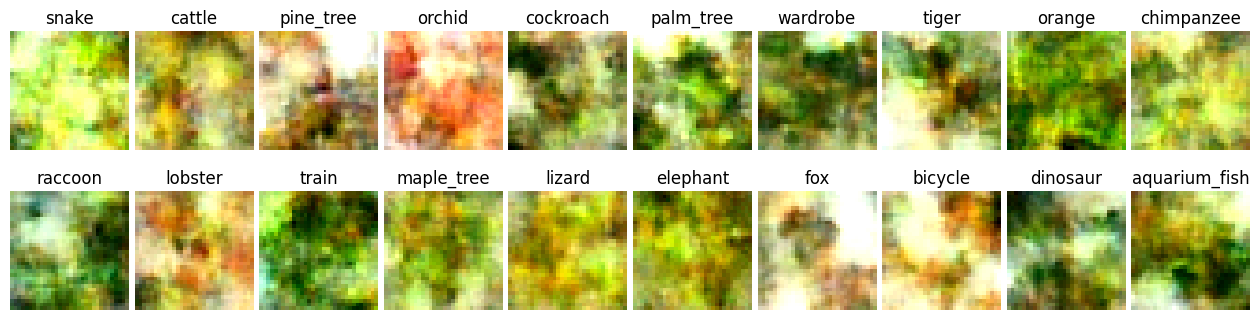

 99%|█████████▉| 395/400 [02:10<00:01,  3.03it/s]

In [ ]:
losses = []
batch = 125

for epoch in range(100): # n epochs
    for i in tqdm(range(0, len(images), batch), ): # loop over the images in a batch
        x, c = images[i:i+batch], labels[i:i+batch]
        #x = transforms(x)

        t = diffusion.sample_timesteps(batch).to(device)
        noised, noise = diffusion.noise_images(x, t) # noise the batch
        noised, noise = noised.to(device), noise.to(device)

        opt.zero_grad()
        t = t.unsqueeze(-1)

        yhat = model(noised, t, c) # predict the noise added to images with the model
        loss = loss_fn(yhat, noise) # calculate how wrong the prediction is

        losses += [loss.cpu().detach().numpy()]

        loss.backward() # backpropagate the loss through the parameters
        opt.step() # gradient descent over the params
            
    if epoch % 5 == 0: # every 5 epochs display 5 sampled images
        sampled, classes = diffusion.sample(model)
        fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(16, 9))

        fig.subplots_adjust(hspace=-0.7, wspace=0.05)
        for i, img in enumerate(sampled):
            axes[i // 10, i % 10].imshow(normalise(img).cpu().detach().numpy().swapaxes(0, 2).swapaxes(0, 1))
            axes[i // 10, i % 10].axis('off')
            axes[i // 10, i % 10].set_title(metadata[b'fine_label_names'][classes[i]].decode())

            torch.save(model, '/kaggle/working/cifar100-21-04')

        plt.show()

In [ ]:
plt.plot(losses)

In [ ]:
t[:10].T

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 9))
i = 0
sf = (1-diffusion.alpha_hat[t[i].to(torch.long)]).sqrt()

axes[0].imshow(normalise(yhat[i]).cpu().detach().numpy().swapaxes(0, 2).swapaxes(0, 1))
axes[1].imshow(normalise(noised[i] - yhat[i]*sf).cpu().detach().numpy().swapaxes(0, 2).swapaxes(0, 1))
axes[2].imshow(normalise(noised[i]).cpu().detach().numpy().swapaxes(0, 2).swapaxes(0, 1))
axes[3].imshow(normalise(noised[i] - noise[i]*sf).cpu().detach().numpy().swapaxes(0, 2).swapaxes(0, 1))

In [ ]:
torch.save(model, '/kaggle/working/cifar100-18-04')

In [19]:
model = torch.load('/kaggle/input/cifar-10-03/cifar100-10-03').to(device)

In [22]:
noised = torch.randn((1, 3, 32, 32)).to(device)
t = torch.tensor([499]).to(device)
c = torch.tensor([0]).to(device)

In [ ]:
steps = []
times = []

for i in range(1, 102, 5):
    print(i)
    noised = torch.randn((i, 3, 32, 32)).to(device)
    t = torch.tensor([499]).to(device)
    c = torch.ones(i).to(torch.long).to(device)
    
    t1 = time.time()
    diffusion.denoise(model, noised, torch.tensor([t]).to(device), c, jumps=25)
    t2 = time.time()
    
    steps += [i]
    times += [t2 - t1]

In [ ]:
times = np.array(times)
ngens = np.array(steps)

In [ ]:
plt.plot(ngens / times, times)

In [ ]:
plt.plot(ngens, ngens / times)
plt.xlabel('ngens')
plt.ylabel('gens / s')

In [ ]:
times

In [ ]:
plt.plot(times, steps)
plt.xlabel('time')
plt.ylabel('ngens')

In [ ]:
torch.randn((1, 3, 32, 32)).to(device)
t = torch.tensor([499]).to(device)
c = torch.tensor([0]).to(device)

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(25, 25))

fig.subplots_adjust(hspace=-0.85, wspace=0.05)
for i, img in enumerate(denoiseds[:20]):
    axes[i // 10, i % 10].imshow(normalise(img.squeeze()).cpu().detach().numpy().swapaxes(0, 2).swapaxes(0, 1))
    axes[i // 10, i % 10].axis('off')

plt.show()

In [ ]:
apple.shape

In [ ]:
c = torch.ones((20,)).to(torch.long).to(device) * 0
sampled, classes = diffusion.sample(model, ngens=20, c=c)

fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(16, 9))

fig.subplots_adjust(hspace=0.2, wspace=0.05)
for i, img in enumerate(sampled):
    axes[i // 5, i % 5].imshow(normalise(img).cpu().detach().numpy().swapaxes(0, 2).swapaxes(0, 1))
    axes[i // 5, i % 5].axis('off')
    axes[i // 5, i % 5].set_title(metadata[b'fine_label_names'][classes[i]].decode())

plt.show()

In [ ]:
metadata[b'fine_label_names'].index(b'apple')

In [ ]:
mask = labels == metadata[b'fine_label_names'].index(b'apple')
plates = images[torch.nonzero(mask).squeeze()]

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(16, 9))

fig.subplots_adjust(hspace=0.2, wspace=0.05)
for i, img in enumerate(plates[:20]):
    axes[i // 5, i % 5].imshow(normalise(img).cpu().detach().numpy().swapaxes(0, 2).swapaxes(0, 1))
    axes[i // 5, i % 5].axis('off')

plt.show()

In [ ]:
import time

In [ ]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
#count_parameters(model)

In [ ]:
count = 0

for i in model.named_parameters():
    count += 1

In [ ]:
count

In [ ]:
import torch.autograd.profiler as profiler

# Create a profiler
with profiler.profile(use_cuda=True) as prof:
    # Profile your model's forward pass
    output = model(noised, t, c)

# Print the profiler results
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

In [ ]:
pip install thop

In [ ]:
import thop

# Create a dummy input tensor
input_tensor = torch.randn(1, 3, 224, 224)

# Estimate FLOPS
flops, params = thop.profile(model, inputs=(noised, t, c))
print(f"FLOPS: {flops:.2f} GFLOPS")

In [ ]:
flops

In [ ]:
params